# Notebook 2: Final Model Training

**Goal:** Train the model architecture using the best hyperparameters identified in Notebook 1 (`01_Hyperparameter_Optimization.ipynb`), employing early stopping to prevent overfitting and save the best performing model weights.

**Setup for this Run:**
*   **Model:** [Specify e.g., ResNet18]
*   **Unfreeze Strategy:** [Specify e.g., 'mid']
*   **Data Augmentation:** [Specify e.g., True/False]
*   **Best Hyperparameters:** Loaded from file generated by Notebook 1.

This notebook will:
1. Define the experimental setup parameters (matching Notebook 1).
2. Load the best hyperparameters identified during HPO.
3. Set up the data loaders, model, and optimizer using these best parameters.
4. Run the main training loop for a larger number of epochs.
5. Implement early stopping based on validation performance.
6. Save the `state_dict` of the model from the epoch with the best validation performance.
7. Save the full training and validation history (loss and accuracy per epoch).
8. Visualize the training curves.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import os
import copy # To store best model state
from tqdm.notebook import tqdm # For progress bars
import matplotlib.pyplot as plt

# Import utility functions
import utils

# --- Define Setup for this Notebook Run ---
# MUST MATCH the setup used in Notebook 1 for which HPO was run

# Unique identifier for this experimental setup (used for loading/saving files)
SETUP_ID = 'resnet_mid_aug' # <<< CHANGE THIS TO MATCH THE HPO RUN >>>

MODEL_NAME = 'resnet'          # 'resnet' or 'mobilenet'
UNFREEZE_STRATEGY = 'mid'     # 'head', 'mid', or 'deep'
AUGMENT_TRAIN = True          # True or False

# Final Training Parameters
MAX_EPOCHS = 50               # Maximum number of epochs to train
PATIENCE = 15                 # Early stopping patience (epochs to wait after last improvement)
BATCH_SIZE = 64               # Batch size for training

# --- Device Setup ---
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# --- Unfreeze Strategy Mapping ---
resnet_unfreeze_map = {
    'head': ['fc.'],
    'mid':  ['fc.', 'layer4.'],
    'deep': ['fc.', 'layer4.', 'layer3.']
}
mobilenet_unfreeze_map = {
    'head': ['classifier.3.'],
    'mid':  ['classifier.3.', 'features.10.', 'features.11.', 'features.12.'],
    'deep': ['classifier.3.', 'features.8.', 'features.9.', 'features.10.', 'features.11.', 'features.12.']
}
if MODEL_NAME == 'resnet':
    layers_to_unfreeze = resnet_unfreeze_map[UNFREEZE_STRATEGY]
elif MODEL_NAME == 'mobilenet':
    layers_to_unfreeze = mobilenet_unfreeze_map[UNFREEZE_STRATEGY]

# --- Filenames ---
# Input file from Notebook 1
best_params_filename = f"best_params_{SETUP_ID}.json"
# Output files for this notebook
best_model_filename = f"best_model_{SETUP_ID}.pth"
train_history_filename = f"train_history_{SETUP_ID}.json"

print(f"Setup ID: {SETUP_ID}")
print(f"Model: {MODEL_NAME}, Unfreeze: {UNFREEZE_STRATEGY}, Augment: {AUGMENT_TRAIN}")
print(f"Max Epochs: {MAX_EPOCHS}, Patience: {PATIENCE}")
print(f"Layers to unfreeze contain: {layers_to_unfreeze}")

Using device: mps
Setup ID: resnet_mid_aug
Model: resnet, Unfreeze: mid, Augment: True
Max Epochs: 50, Patience: 15
Layers to unfreeze contain: ['fc.', 'layer4.']


In [2]:
# Load the best hyperparameters identified in Notebook 1
print(f"Loading best hyperparameters from: {best_params_filename}")
# Add check if file exists? No error handling per request.
best_hyperparams = utils.load_json(best_params_filename)

print(f"Using hyperparameters: {best_hyperparams}")

# Extract specific hyperparameters for clarity
LR_HEAD = best_hyperparams['lr_head']
LR_BACKBONE = best_hyperparams['lr_backbone']
WEIGHT_DECAY = best_hyperparams['weight_decay']

Loading best hyperparameters from: best_params_resnet_mid_aug.json
Using hyperparameters: {'lr_backbone': 0.0001, 'lr_head': 0.005, 'weight_decay': 0.01}


In [3]:
# 1. Load Model and Weights Object
model, weights_obj = utils.get_model(MODEL_NAME)

# 2. Load Datasets and DataLoaders
train_dataset, val_dataset = utils.get_datasets(
    task = 'trainval',
    augment_train=AUGMENT_TRAIN,
    weights_obj=weights_obj
    )
test_dataset = utils.get_datasets(
    task = 'test',
    augment_train=False,  # Test set should not be augmented
    weights_obj=weights_obj
)

train_loader = utils.get_dataloaders(task='train', dataset=train_dataset, batch_size=BATCH_SIZE)
val_loader = utils.get_dataloaders(task='val', dataset=val_dataset, batch_size=BATCH_SIZE)
test_loader = utils.get_dataloaders(task='test', dataset=test_dataset, batch_size=BATCH_SIZE)

print(f"DataLoaders created. Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

Dataset split: Train samples = 2944, Val samples = 736
DataLoaders created. Train batches: 46, Val batches: 6


In [4]:
# 3. Adapt Head and Apply Unfreeze Strategy
model = utils.adapt_model_head(model, MODEL_NAME)
model = utils.apply_unfreeze_logic(model, layers_to_unfreeze)
model.to(device) # Move model to device *after* modifications
print(f"Model '{MODEL_NAME}' adapted and layers unfrozen according to '{UNFREEZE_STRATEGY}'.")

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params: {total_params}, Trainable params: {trainable_params} ({100 * trainable_params / total_params:.2f}%)")

Model 'resnet' adapted and layers unfrozen according to 'mid'.
Total params: 11195493, Trainable params: 8412709 (75.14%)


In [5]:
# 4. Setup Optimizer using loaded best hyperparameters
optimizer = utils.get_optimizer(
    model=model,
    lr_head=LR_HEAD,
    lr_backbone=LR_BACKBONE,
    weight_decay=WEIGHT_DECAY
)
print("Optimizer created with loaded best hyperparameters.")

# 5. Define Loss Function
criterion = nn.CrossEntropyLoss()
print("Loss function (CrossEntropyLoss) defined.")

Optimizer created with loaded best hyperparameters.
Loss function (CrossEntropyLoss) defined.


In [6]:
def train_model(model, 
                criterion, 
                optimizer, 
                train_loader, 
                val_loader, 
                device, 
                max_epochs, 
                patience):
    """
    Trains the model with early stopping based on validation accuracy.
    Saves the best model state dictionary in memory.
    Returns the best model state_dict and the training history.
    """
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_model_wts = None # copy.deepcopy(model.state_dict()) # Initialize with starting weights? Or wait for first improvement.
    best_val_accuracy = -1.0 # Initialize best accuracy
    epochs_no_improve = 0     # Counter for early stopping

    total_start_time = time.time()

    for epoch in range(max_epochs):
        epoch_start_time = time.time()
        print(f"\n--- Epoch {epoch+1}/{max_epochs} ---")

        # --- Training Phase ---
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        train_pbar = tqdm(train_loader, desc="Training", leave=False)

        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0) # Accumulate loss weighted by batch size
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            train_pbar.set_postfix(loss=loss.item())

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = 100 * correct_train / total_train
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        print(f"Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.2f}%")

        # --- Validation Phase ---
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0
        val_pbar = tqdm(val_loader, desc="Validation", leave=False)

        with torch.no_grad():
            for inputs, labels in val_pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_acc = 100 * correct_val / total_val
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        epoch_end_time = time.time()
        print(f"Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.2f}% | Time: {epoch_end_time - epoch_start_time:.2f}s")

        # --- Check for Improvement & Early Stopping ---
        if epoch_val_acc > best_val_accuracy:
            print(f"Validation accuracy improved ({best_val_accuracy:.2f}% -> {epoch_val_acc:.2f}%). Saving model...")
            best_val_accuracy = epoch_val_acc
            best_model_wts = copy.deepcopy(model.state_dict()) # Save the best weights
            epochs_no_improve = 0 # Reset counter
            # Save best model weights immediately to file
            torch.save(best_model_wts, best_model_filename)
            print(f"Best model weights saved to {best_model_filename}")

        else:
            epochs_no_improve += 1
            print(f"No improvement in validation accuracy for {epochs_no_improve} epoch(s).")
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break # Exit training loop

    total_end_time = time.time()
    print(f"\nTraining Finished. Total time: {(total_end_time - total_start_time)/60:.2f} minutes")
    print(f"Best Validation Accuracy Achieved: {best_val_accuracy:.2f}%")

    # Load best model weights back into model before returning (optional, depends if you want the function caller to have it)
    if best_model_wts:
        model.load_state_dict(best_model_wts)
    # else: could mean training didn't improve beyond initial state if not initialized

    return model, history # Return model with best weights loaded and history

In [7]:
print("Starting final training process...")

# Call the training function
# The function handles the loop, early stopping, and saving the best model to file
final_model, training_history = train_model(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    max_epochs=2,
    patience=PATIENCE
)

print("Final training complete.")

# Save the full training history (list of dictionaries)
utils.save_json(training_history, train_history_filename)
print(f"Training history saved to: {train_history_filename}")

Starting final training process...

--- Epoch 1/2 ---


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 1.2771 Acc: 64.71%


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Val Loss: 0.4660 Acc: 84.38% | Time: 43.18s
Validation accuracy improved (-1.00% -> 84.38%). Saving model...
Best model weights saved to best_model_resnet_mid_aug.pth

--- Epoch 2/2 ---


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 0.3264 Acc: 89.98%


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Val Loss: 0.4611 Acc: 84.65% | Time: 44.49s
Validation accuracy improved (84.38% -> 84.65%). Saving model...
Best model weights saved to best_model_resnet_mid_aug.pth

Training Finished. Total time: 1.47 minutes
Best Validation Accuracy Achieved: 84.65%
Final training complete.
Training history saved to: train_history_resnet_mid_aug.json


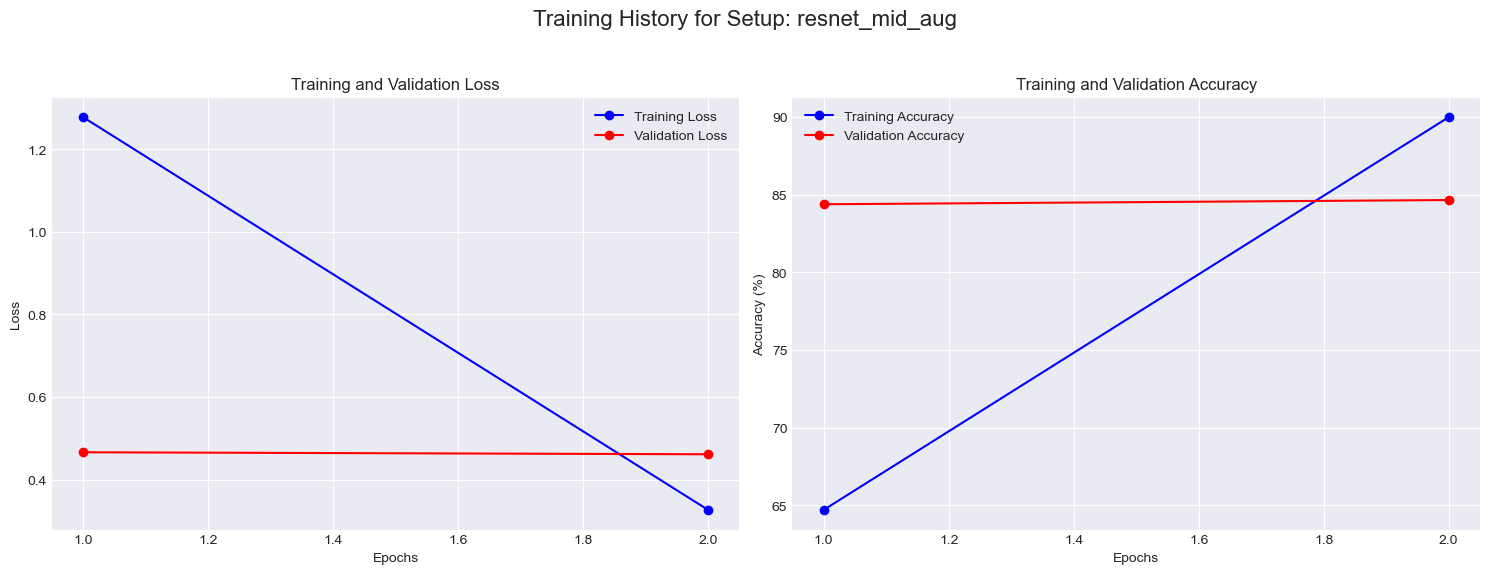

In [8]:
# Plot the training and validation loss and accuracy

epochs_ran = len(training_history['train_loss'])
epochs = range(1, epochs_ran + 1)

plt.style.use('seaborn-v0_8-darkgrid') # Use a nice style
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Loss Plot
ax1.plot(epochs, training_history['train_loss'], 'bo-', label='Training Loss')
ax1.plot(epochs, training_history['val_loss'], 'ro-', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Accuracy Plot
ax2.plot(epochs, training_history['train_acc'], 'bo-', label='Training Accuracy')
ax2.plot(epochs, training_history['val_acc'], 'ro-', label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

fig.suptitle(f'Training History for Setup: {SETUP_ID}', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

## Final Training Summary

The final training for setup `[SETUP_ID]` is complete.

*   Training ran for **[epochs_ran]** epochs before stopping (due to max epochs or early stopping).
*   The best validation accuracy achieved was **[Best Validation Accuracy]%**.
*   The weights of the best performing model have been saved to `best_model_[SETUP_ID].pth`.
*   The full training history (loss and accuracy per epoch) has been saved to `train_history_[SETUP_ID].json`.

Proceed to `03_Evaluation_and_Analysis.ipynb` to evaluate this saved model on the test set.